In [6]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


%matplotlib inline

In [7]:
x = np.linspace(0, 5, 20)
x

array([ 0.        ,  0.26315789,  0.52631579,  0.78947368,  1.05263158,
        1.31578947,  1.57894737,  1.84210526,  2.10526316,  2.36842105,
        2.63157895,  2.89473684,  3.15789474,  3.42105263,  3.68421053,
        3.94736842,  4.21052632,  4.47368421,  4.73684211,  5.        ])

In [8]:
M1, M2 = np.meshgrid(x, x)
M1.shape, M2.shape

((20, 20), (20, 20))

In [9]:
X = np.column_stack([M1.flatten(), M2.flatten()])
print("The shape I want: {}".format(X.shape))

def fancy_function(X): pass

fancy_function(X)

The shape I want: (400, 2)


# Gridspace interface

In [10]:
# pass a list of arrays into gridspace
def gridspace1(linspaces): pass


gridspace1([x])
gridspace1([x, x])
gridspace1([x, x, x])

In [11]:
def gridspace2(params): pass


gridspace2([(0, 5, 50)])
gridspace2([(0, 5, 50), (0, 2, 50)])
gridspace2([(0, 5, 50), (0, 2, 10, False), (-3, 1)])

In [12]:
def gridspace3(params, repeat=None): pass


gridspace3([(0, 5, 50)], repeat=2)
gridspace3([(0, 5, 50)], repeat=3)

In [13]:
def gridspace4(linspaces=None, params=None, repeat=None): pass


gridspace4(linspaces=[x], repeat=2)
gridspace4(linspaces=[x], repeat=3)

The first interface is the most general. You cann pass in whatever you want.

# Benchmarks

In [14]:
def cartesian1(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian1(arrays[1:], out=out[0:m, 1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [15]:
def cartesian2(arrays):
    arrays = [np.asarray(a) for a in arrays]
    shape = (len(x) for x in arrays)

    ix = np.indices(shape, dtype=int)
    ix = ix.reshape(len(arrays), -1).T

    for n, arr in enumerate(arrays):
        ix[:, n] = arrays[n][ix[:, n]]

    return ix

In [16]:
import itertools
def cartesian3(arrays):
    return np.array([stuff for stuff in itertools.product(*arrays)])

In [17]:
def cartesian4(spaces):
    return np.column_stack([space.flatten()
                            for space in np.meshgrid(*spaces)])

In [18]:
def cartesian5(arrays, out=None):
    arrays = [np.asarray(x).ravel() for x in arrays]
    dtype = np.result_type(*arrays)

    n = np.prod([arr.size for arr in arrays])
    if out is None:
        out = np.empty((len(arrays), n), dtype=dtype)
    else:
        out = out.T

    for j, arr in enumerate(arrays):
        n /= arr.size
        out.shape = (len(arrays), -1, arr.size, n)
        out[j] = arr[np.newaxis, :, np.newaxis]
    out.shape = (len(arrays), -1)

    return out.T

In [19]:
import collections
Run = collections.namedtuple("Run", "ns m")

runs = [
    Run([3, 10, 100, 500, 1000, 2000], 2),
    Run([3, 10, 50, 100], 3),
    Run([3, 10], 4),
]

In [23]:
from functools import partial
import timeit
import pandas as pd


def benchmark(runs):
    results = []    
    for run in runs:
        for n in run.ns:
            print("==============================================================")
            print("Testing n={} m={}".format(n, run.m))
            
            dom = np.linspace(0, 1, n)
            arrays = [dom for _ in range(run.m)]
            
            for f in [cartesian1, cartesian2, cartesian3, cartesian4, cartesian5]:
                fname = f.__name__
                f = partial(f, arrays)
                duration = timeit.timeit(f, number=20)
                
                d = {"n": n, "m": run.m, "fname": fname, "time": duration }
                print(d)
                results.append(d)
                
    return pd.DataFrame(results)

In [24]:
results = benchmark(runs)

Testing n=3 m=2
{'time': 0.0020809173583984375, 'm': 2, 'fname': 'cartesian1', 'n': 3}
{'time': 0.0012841224670410156, 'm': 2, 'fname': 'cartesian2', 'n': 3}
{'time': 0.0003829002380371094, 'm': 2, 'fname': 'cartesian3', 'n': 3}
{'time': 0.0013501644134521484, 'm': 2, 'fname': 'cartesian4', 'n': 3}
{'time': 0.0010561943054199219, 'm': 2, 'fname': 'cartesian5', 'n': 3}
Testing n=10 m=2
{'time': 0.0021979808807373047, 'm': 2, 'fname': 'cartesian1', 'n': 10}
{'time': 0.0012180805206298828, 'm': 2, 'fname': 'cartesian2', 'n': 10}
{'time': 0.0015521049499511719, 'm': 2, 'fname': 'cartesian3', 'n': 10}
{'time': 0.0013489723205566406, 'm': 2, 'fname': 'cartesian4', 'n': 10}
{'time': 0.0010411739349365234, 'm': 2, 'fname': 'cartesian5', 'n': 10}
Testing n=100 m=2
{'time': 0.009801864624023438, 'm': 2, 'fname': 'cartesian1', 'n': 100}
{'time': 0.0034689903259277344, 'm': 2, 'fname': 'cartesian2', 'n': 100}
{'time': 0.09063100814819336, 'm': 2, 'fname': 'cartesian3', 'n': 100}
{'time': 0.0032708

In [26]:
import pickle
with open("cartesian_benchmark.pkl", "w") as f:
   pickle.dump(results, f)

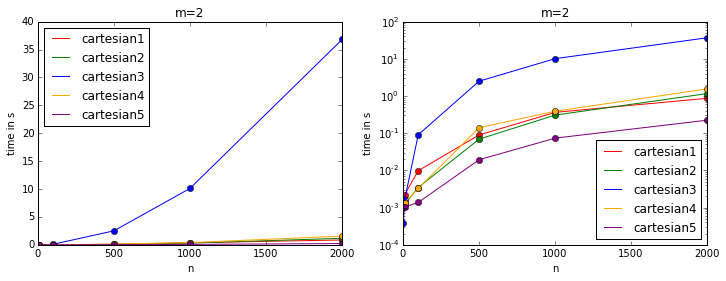

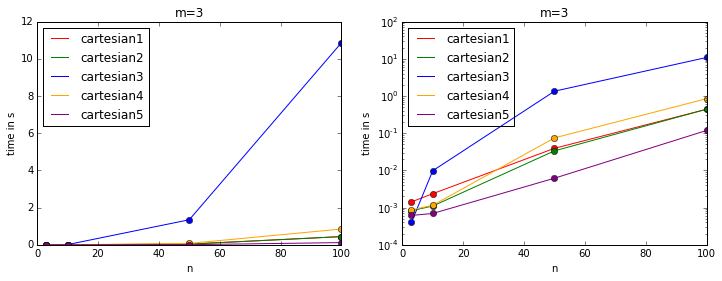

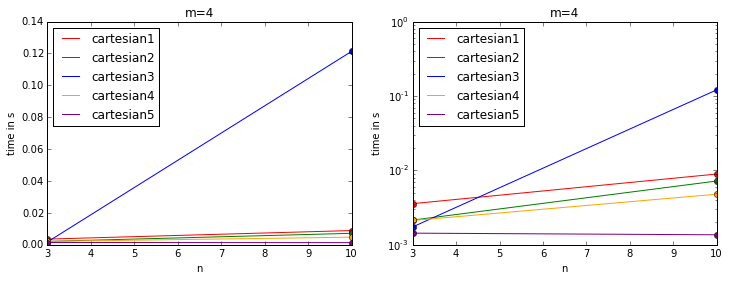

In [27]:
# pandas legend does not work properly for groupby
for i in [2, 3, 4]:
    subset = results.ix[results["m"] == i]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    colors = "red green blue orange purple".split()
    
    for c, (name, group) in enumerate(subset.groupby("fname")):
        axes[0].plot(group["n"], group["time"], "-", color=colors[c], label=name)
        axes[0].plot(group["n"], group["time"], "o", color=colors[c])
        axes[0].set_xlabel("n")
        axes[0].set_ylabel("time in s")

        axes[1].plot(group["n"], group["time"], "-", color=colors[c], label=name)
        axes[1].plot(group["n"], group["time"], "o", color=colors[c])
        axes[1].set_xlabel("n")
        axes[1].set_ylabel("time in s")


        axes[1].set_yscale("log")
        
    axes[0].legend(loc=0)
    axes[1].legend(loc=0)
    title = "m={}".format(i)
    axes[0].set_title(title)
    axes[1].set_title(title)